In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = r'F:\Dataset for Images\Moths image classification'

In [3]:

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [5]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms['test'])
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=data_transforms['valid'])

In [6]:

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [7]:
class_names = train_dataset.classes
num_classes = len(class_names)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


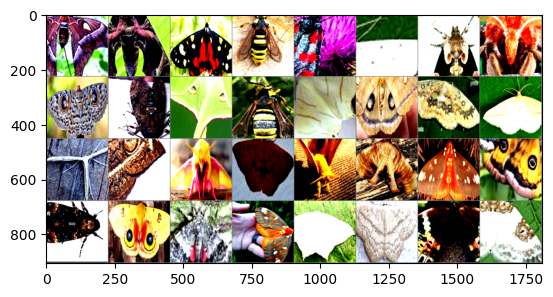

In [8]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [10]:
model=models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)

In [11]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, train_loader, valid_loader, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(valid_loader.dataset)
        epoch_acc = running_corrects.double() / len(valid_loader.dataset)
        print(f'Valid Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best Val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, train_loader, valid_loader, optimizer, scheduler, num_epochs=10)

Epoch 0/9
----------
Train Loss: 2.2852 Acc: 0.5226
Valid Loss: 0.5306 Acc: 0.9360
Epoch 1/9
----------
Train Loss: 0.8068 Acc: 0.8320
Valid Loss: 0.2287 Acc: 0.9640
Epoch 2/9
----------
Train Loss: 0.5682 Acc: 0.8665
Valid Loss: 0.1880 Acc: 0.9680
Epoch 3/9
----------
Train Loss: 0.4762 Acc: 0.8836
Valid Loss: 0.1619 Acc: 0.9680
Epoch 4/9
----------
Train Loss: 0.4086 Acc: 0.8941
Valid Loss: 0.1559 Acc: 0.9720
Epoch 5/9
----------
Train Loss: 0.3608 Acc: 0.9070
Valid Loss: 0.1416 Acc: 0.9760
Epoch 6/9
----------
Train Loss: 0.3438 Acc: 0.9087
Valid Loss: 0.1415 Acc: 0.9680
Epoch 7/9
----------
